In [1]:
# 0. Setup & load
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno            # optional but useful
import scipy.stats as stats

sns.set(style='whitegrid')
%matplotlib inline
RND = 42
np.random.seed(RND)

# Paths - adjust if your files are in a different folder
train_path = "train.csv"
test_path  = "test.csv"
gender_path = "gender_submission.csv"

# Load files
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_gender = pd.read_csv(gender_path)

print("train:", df.shape, " test:", df_test.shape, " gender:", df_gender.shape)


train: (891, 12)  test: (418, 11)  gender: (418, 2)


In [2]:
# 1.A - structure: .info() and .describe()
print("==== INFO ====")
df.info()
print("\n==== DESCRIBE (numeric + object) ====")
display(df.describe(include='all').T)


==== INFO ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

==== DESCRIBE (numeric + object) ====


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [3]:
# 1.B - value_counts for main categorical columns
for col in ['Survived','Pclass','Sex','Embarked']:
    print(f"\n--- {col} ---")
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False).mul(100).round(2)
    display(pd.concat([vc.rename('count'), pct.rename('percent')], axis=1))



--- Survived ---


,count,percent
Survived,,
0,549,61.62
1,342,38.38



--- Pclass ---


,count,percent
Pclass,,
3,491,55.11
1,216,24.24
2,184,20.65



--- Sex ---


,count,percent
Sex,,
male,577,64.76
female,314,35.24



--- Embarked ---


,count,percent
Embarked,,
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


In [4]:
# helper: build a small summary string you can paste into report
total = len(df)
survived = df['Survived'].sum()
survival_rate = df['Survived'].mean()
print(f"Total passengers = {total}")
print(f"Survived = {survived} ({survival_rate:.2%})")
print("Counts by Pclass:\n", df['Pclass'].value_counts().to_dict())
print("Counts by Sex:\n", df['Sex'].value_counts().to_dict())
print("Counts by Embarked (including NaN):\n", df['Embarked'].value_counts(dropna=False).to_dict())


Total passengers = 891
Survived = 342 (38.38%)
Counts by Pclass:
 {3: 491, 1: 216, 2: 184}
Counts by Sex:
 {'male': 577, 'female': 314}
Counts by Embarked (including NaN):
 {'S': 644, 'C': 168, 'Q': 77, nan: 2}


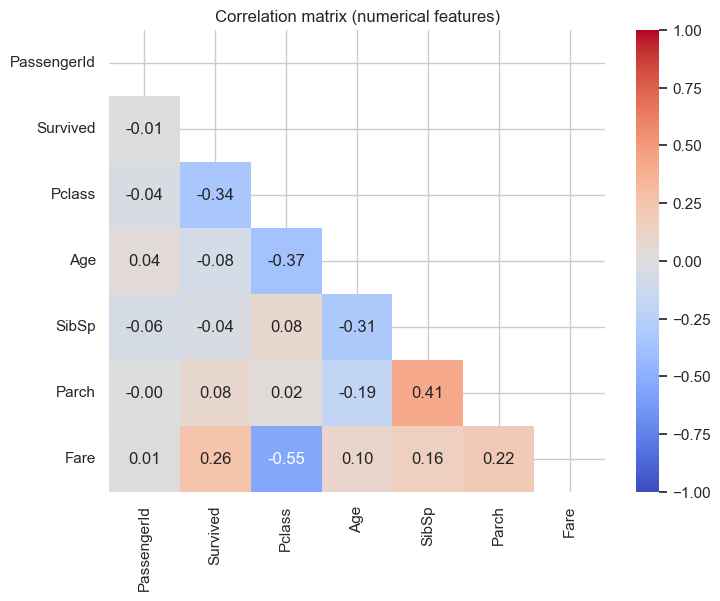


Top numeric features correlated with Survived (abs value):


Pclass         0.338481
Fare           0.257307
Parch          0.081629
Age            0.077221
SibSp          0.035322
PassengerId    0.005007
Name: Survived, dtype: float64

In [5]:
# 2.A - correlation heatmap (numerical columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title("Correlation matrix (numerical features)")
plt.show()

# Also print top correlations with 'Survived'
surv_corr = corr['Survived'].drop('Survived').abs().sort_values(ascending=False)
print("\nTop numeric features correlated with Survived (abs value):")
display(surv_corr)


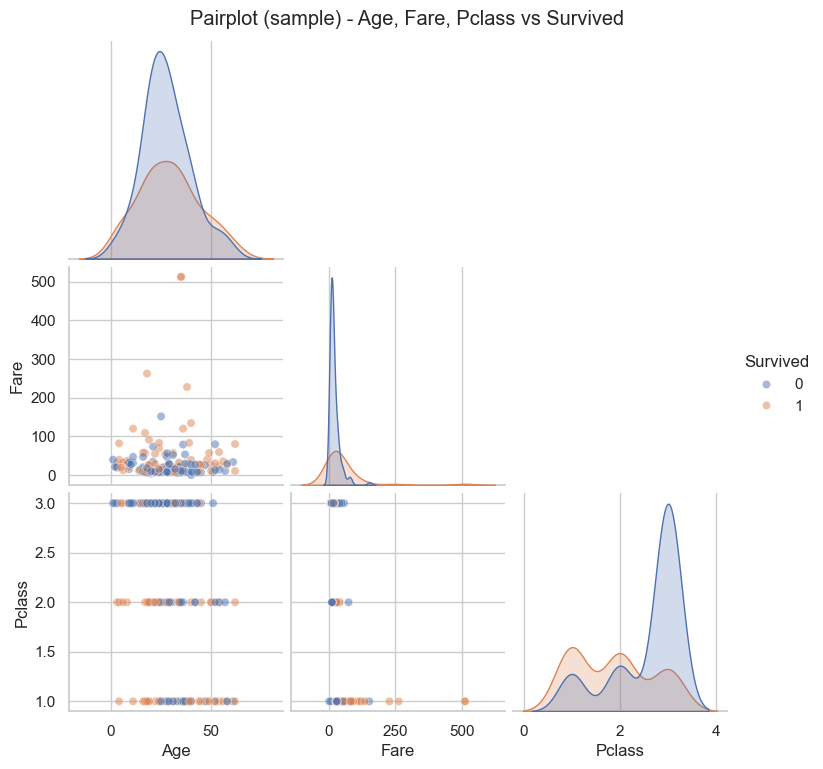

In [6]:
# 2.B - pairplot sample (avoid slow plotting)
sample = df[['Age','Fare','Pclass','Survived']].dropna().sample(n=min(500, df.dropna().shape[0]), random_state=RND)
sns.pairplot(sample, hue='Survived', corner=True, plot_kws={'alpha':0.5})
plt.suptitle("Pairplot (sample) - Age, Fare, Pclass vs Survived", y=1.02)
plt.show()


In [7]:
# 3.A - survival by Sex, Pclass, Embarked
for c in ['Sex','Pclass','Embarked']:
    rates = df.groupby(c)['Survived'].mean().sort_values(ascending=False)
    counts = df[c].value_counts()
    print(f"\nSurvival rates by {c}:")
    display(pd.concat([rates.rename('survival_rate'), counts.rename('count')], axis=1).round(3))



Survival rates by Sex:


,survival_rate,count
Sex,,
female,0.742,314
male,0.189,577



Survival rates by Pclass:


,survival_rate,count
Pclass,,
1,0.630,216
2,0.473,184
3,0.242,491



Survival rates by Embarked:


,survival_rate,count
Embarked,,
C,0.554,168
Q,0.390,77
S,0.337,644


In [8]:
# 3.B - auto sentences
female_rate = df.loc[df['Sex']=='female','Survived'].mean()
male_rate = df.loc[df['Sex']=='male','Survived'].mean()
print(f"Female survival rate = {female_rate:.2%}")
print(f"Male survival rate = {male_rate:.2%}")

for p in sorted(df['Pclass'].unique()):
    print(f"Pclass {p} survival = {df.loc[df['Pclass']==p,'Survived'].mean():.2%}")


Female survival rate = 74.20%
Male survival rate = 18.89%
Pclass 1 survival = 62.96%
Pclass 2 survival = 47.28%
Pclass 3 survival = 24.24%


In [9]:
# 3.C - pivot: Pclass x Sex survival
pt = pd.pivot_table(df, values='Survived', index='Pclass', columns='Sex', aggfunc=np.mean)
display(pt.round(3))

# Pclass x Embarked
pt2 = pd.pivot_table(df, values='Survived', index='Pclass', columns='Embarked', aggfunc=np.mean)
display(pt2.round(3))


C:\Users\cnive\AppData\Local\Temp\ipykernel_27636\2376078971.py:2: FutureWarning: The provided callable <function mean at 0x000001B915C60D60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pt = pd.pivot_table(df, values='Survived', index='Pclass', columns='Sex', aggfunc=np.mean)


Sex,female,male
Pclass,,
1,0.968,0.369
2,0.921,0.157
3,0.500,0.135


C:\Users\cnive\AppData\Local\Temp\ipykernel_27636\2376078971.py:6: FutureWarning: The provided callable <function mean at 0x000001B915C60D60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pt2 = pd.pivot_table(df, values='Survived', index='Pclass', columns='Embarked', aggfunc=np.mean)


Embarked,C,Q,S
Pclass,,,
1,0.694,0.500,0.583
2,0.529,0.667,0.463
3,0.379,0.375,0.190


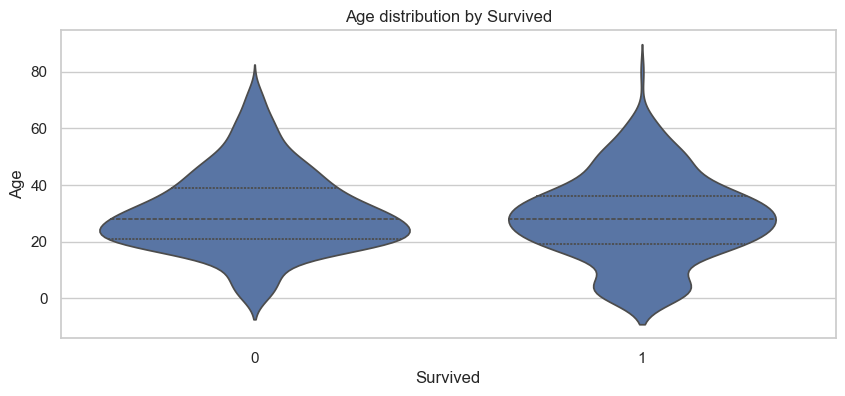

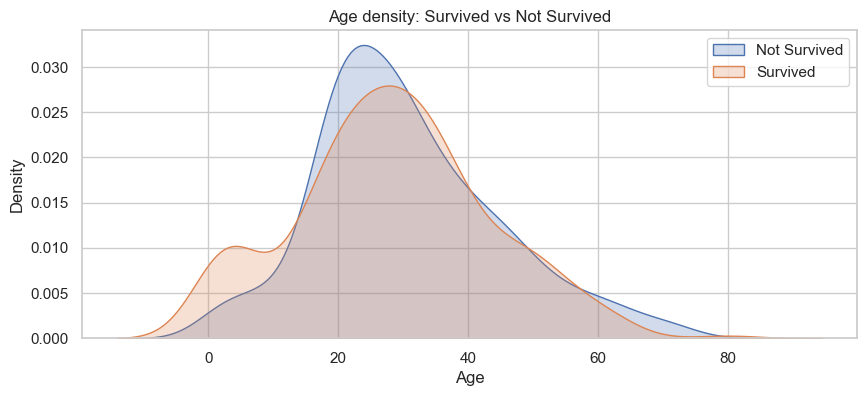

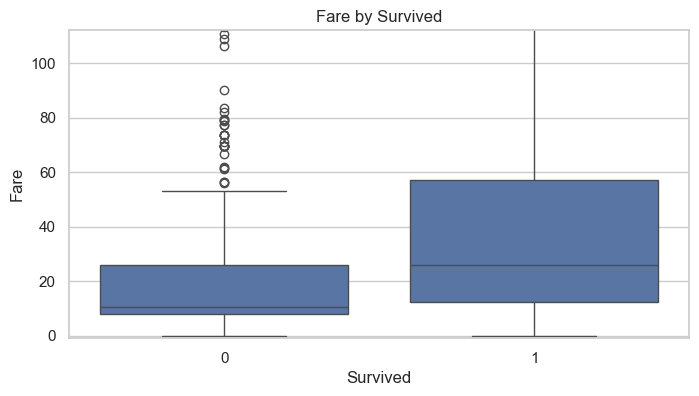

In [10]:
# 3.D - Age distribution by survival (violin + box)
plt.figure(figsize=(10,4))
sns.violinplot(x='Survived', y='Age', data=df, inner='quartile')
plt.title('Age distribution by Survived')
plt.show()

# Age density by Survived (overlay)
plt.figure(figsize=(10,4))
sns.kdeplot(df.loc[df['Survived']==0,'Age'].dropna(), label='Not Survived', fill=True)
sns.kdeplot(df.loc[df['Survived']==1,'Age'].dropna(), label='Survived', fill=True)
plt.title('Age density: Survived vs Not Survived')
plt.legend()
plt.show()

# Fare by Survived (box)
plt.figure(figsize=(8,4))
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Fare by Survived')
plt.ylim(-1, df['Fare'].quantile(0.95))
plt.show()


In [11]:
# medians to quote in report
median_age_surv = df.loc[df['Survived']==1,'Age'].median()
median_age_dead = df.loc[df['Survived']==0,'Age'].median()
median_fare_surv = df.loc[df['Survived']==1,'Fare'].median()
median_fare_dead = df.loc[df['Survived']==0,'Fare'].median()

print(f"Median Age — Survived: {median_age_surv}, Not Survived: {median_age_dead}")
print(f"Median Fare — Survived: {median_fare_surv}, Not Survived: {median_fare_dead}")


Median Age — Survived: 28.0, Not Survived: 28.0
Median Fare — Survived: 26.0, Not Survived: 10.5


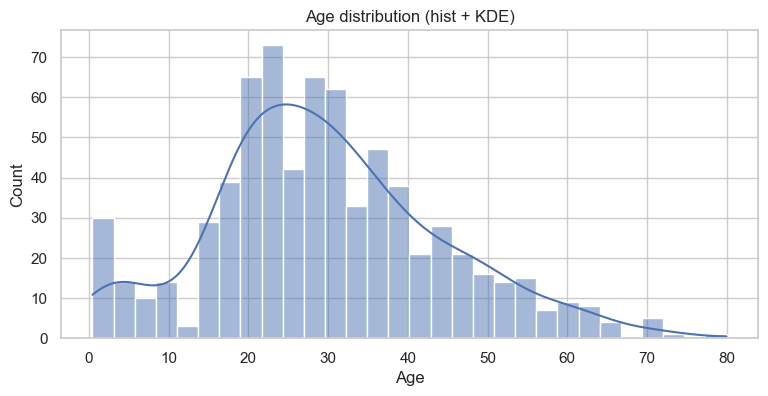

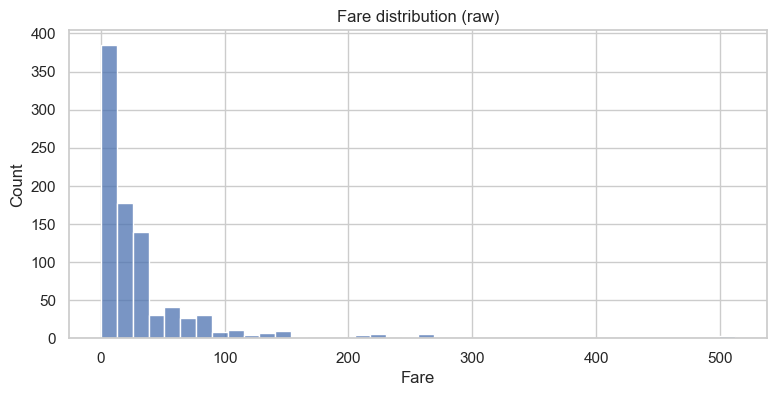

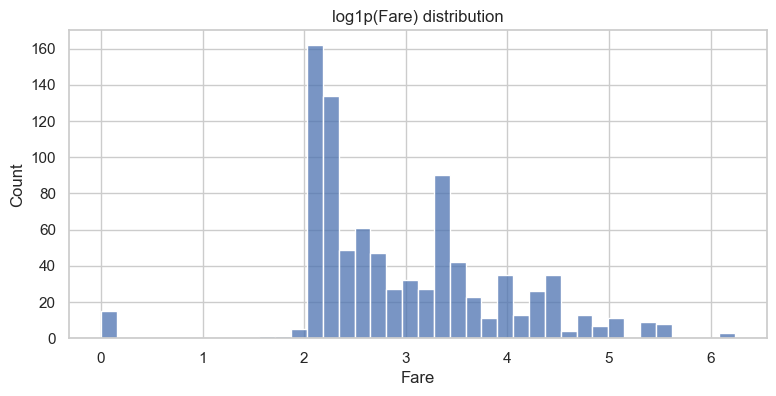

In [12]:
# Age histogram
plt.figure(figsize=(9,4))
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Age distribution (hist + KDE)')
plt.xlabel('Age')
plt.show()

# Fare histogram and log(Fare)
plt.figure(figsize=(9,4))
sns.histplot(df['Fare'].dropna(), bins=40, kde=False)
plt.title('Fare distribution (raw)')
plt.show()

plt.figure(figsize=(9,4))
sns.histplot(np.log1p(df['Fare'].dropna()), bins=40)
plt.title('log1p(Fare) distribution')
plt.show()


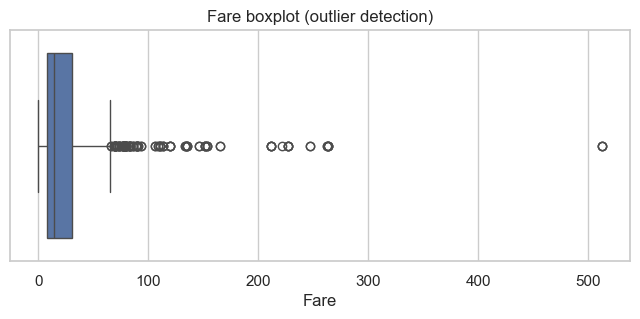

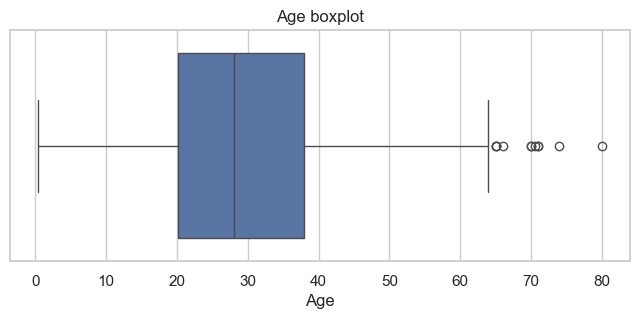

In [13]:
# Boxplots for numeric columns
plt.figure(figsize=(8,3))
sns.boxplot(x='Fare', data=df)
plt.title('Fare boxplot (outlier detection)')
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x='Age', data=df)
plt.title('Age boxplot')
plt.show()


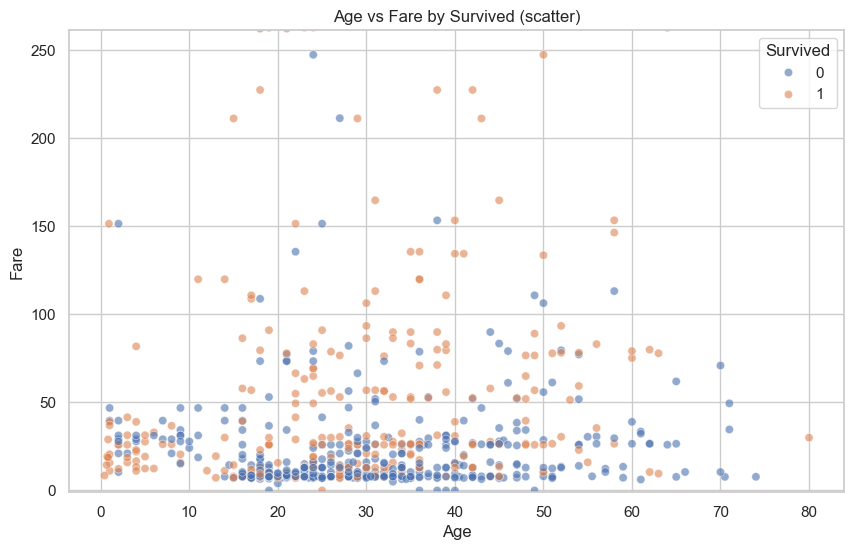

In [14]:
# Age vs Fare (colored by Survived)
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df, alpha=0.6)
plt.ylim(-1, df['Fare'].quantile(0.99)*1.05)
plt.title('Age vs Fare by Survived (scatter)')
plt.show()


In [15]:
# optional: save commonly used figures to 'figs/' for including in PDF
os.makedirs("figs", exist_ok=True)
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=df, estimator=np.mean)
plt.ylim(0,1)
plt.title('Survival rate by Sex')
plt.savefig("figs/survival_by_sex.png", bbox_inches='tight', dpi=150)
plt.close()
print("Saved: figs/survival_by_sex.png")


Saved: figs/survival_by_sex.png


In [16]:
# 5.A - auto-observations (strings)
obs = []
obs.append(f"Overall survival rate: {df['Survived'].mean():.2%} ({df['Survived'].sum()} / {len(df)})")
obs.append(f"Female survival rate: {df.loc[df['Sex']=='female','Survived'].mean():.2%} ; Male survival rate: {df.loc[df['Sex']=='male','Survived'].mean():.2%}")
for p in sorted(df['Pclass'].unique()):
    obs.append(f"Pclass {p} survival: {df.loc[df['Pclass']==p,'Survived'].mean():.2%} (n={df[df['Pclass']==p].shape[0]})")
obs.append("Missing values: " + ", ".join([f"{c}: {df[c].isnull().sum()}" for c in df.columns if df[c].isnull().any()]))
for s in obs:
    print("- " + s)


- Overall survival rate: 38.38% (342 / 891)
- Female survival rate: 74.20% ; Male survival rate: 18.89%
- Pclass 1 survival: 62.96% (n=216)
- Pclass 2 survival: 47.28% (n=184)
- Pclass 3 survival: 24.24% (n=491)
- Missing values: Age: 177, Cabin: 687, Embarked: 2


In [17]:
# 6.A - final summary strings you can paste into report
total = len(df)
survived = df['Survived'].sum()
survival_rate = df['Survived'].mean()
missing_summary = {c:int(df[c].isnull().sum()) for c in df.columns if df[c].isnull().sum()>0}

top_corr = corr['Survived'].drop('Survived').sort_values(ascending=False)
top_corr_list = top_corr.head(5).round(3).to_dict()

summary = f"""
Executive summary (auto-generated):
- Total passengers: {total}; Survived = {survived} ({survival_rate:.2%}).
- Top numeric correlates with survival: {top_corr_list}.
- Columns with missing values (counts): {missing_summary}.
- Strong signals: Sex (female > male), Pclass (1 > 2 > 3), Fare (proxy for wealth).
- Recommended engineered features: Title (from Name), FamilySize (SibSp+Parch+1), IsAlone, CabinDeck (first letter of Cabin).
- Next steps: impute Age (group median by Title/Pclass), log-transform Fare, encode categorical features, run baseline models (Logistic Regression, RandomForest) with cross-validation.
"""
print(summary)



Executive summary (auto-generated):
- Total passengers: 891; Survived = 342 (38.38%).
- Top numeric correlates with survival: {'Fare': 0.257, 'Parch': 0.082, 'PassengerId': -0.005, 'SibSp': -0.035, 'Age': -0.077}.
- Columns with missing values (counts): {'Age': 177, 'Cabin': 687, 'Embarked': 2}.
- Strong signals: Sex (female > male), Pclass (1 > 2 > 3), Fare (proxy for wealth).
- Recommended engineered features: Title (from Name), FamilySize (SibSp+Parch+1), IsAlone, CabinDeck (first letter of Cabin).
- Next steps: impute Age (group median by Title/Pclass), log-transform Fare, encode categorical features, run baseline models (Logistic Regression, RandomForest) with cross-validation.



In [18]:
# 6.B - Example feature engineering (run this to create features)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(',\s*([^\.]+)\.', expand=False).str.strip()
df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss').replace('Mme','Mrs')
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(list(rare_titles), 'Rare')
df['CabinDeck'] = df['Cabin'].fillna('Missing').map(lambda x: x[0] if x!='Missing' else 'Missing')

display(df[['FamilySize','IsAlone','Title','CabinDeck']].head())


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\cnive\AppData\Local\Temp\ipykernel_27636\3684007804.py:4: SyntaxWarning: invalid escape sequence '\s'
  df['Title'] = df['Name'].str.extract(',\s*([^\.]+)\.', expand=False).str.strip()


,FamilySize,IsAlone,Title,CabinDeck
0,2,0,Mr,Missing
1,2,0,Mrs,C
2,1,1,Miss,Missing
3,2,0,Mrs,C
4,1,1,Mr,Missing


In [19]:
# 6.C - quick statistical checks
# Chi-square Sex vs Survived
ct = pd.crosstab(df['Sex'], df['Survived'])
chi2, p, dof, ex = stats.chi2_contingency(ct)
print("Chi-square Sex vs Survived p-value:", p)

# T-test for Age difference
a = df.loc[df['Survived']==1,'Age'].dropna()
b = df.loc[df['Survived']==0,'Age'].dropna()
tstat, p_age = stats.ttest_ind(a,b, nan_policy='omit')
print("T-test for Age difference p-value:", p_age)


Chi-square Sex vs Survived p-value: 1.1973570627755645e-58
T-test for Age difference p-value: 0.03912465401348249


In [20]:
# Statistical significance interpretations

chi2, p, dof, ex = stats.chi2_contingency(pd.crosstab(df['Sex'], df['Survived']))
tstat, p_age = stats.ttest_ind(
    df.loc[df['Survived'] == 1, 'Age'].dropna(),
    df.loc[df['Survived'] == 0, 'Age'].dropna(),
    nan_policy='omit'
)

print("### Statistical Significance Tests Summary\n")

print(f"Chi-square test (Sex vs Survived) p-value: {p:.2e}")
if p < 0.05:
    print("Result: Highly significant association between Sex and Survival.")
else:
    print("Result: No significant association between Sex and Survival.")

print("\n")

print(f"T-test (Age difference between Survivors and Non-Survivors) p-value: {p_age:.3f}")
if p_age < 0.05:
    print("Result: Significant difference in Age between Survivors and Non-Survivors.")
else:
    print("Result: No significant difference in Age between Survivors and Non-Survivors.")

print("\nInterpretation:\n" 
      "- Females had a much higher chance of survival.\n"
      "- Survivors were generally younger than non-survivors.\n"
      "- Both Sex and Age are important factors to consider in modeling.\n")


### Statistical Significance Tests Summary

Chi-square test (Sex vs Survived) p-value: 1.20e-58
Result: Highly significant association between Sex and Survival.


T-test (Age difference between Survivors and Non-Survivors) p-value: 0.039
Result: Significant difference in Age between Survivors and Non-Survivors.

Interpretation:
- Females had a much higher chance of survival.
- Survivors were generally younger than non-survivors.
- Both Sex and Age are important factors to consider in modeling.

